In [319]:
import matplotlib.pyplot as plt
from numpy import pi, sin, cos, linspace, exp, real, imag, abs, conj
from numpy.fft import fft, fftshift

In [102]:
%matplotlib inline

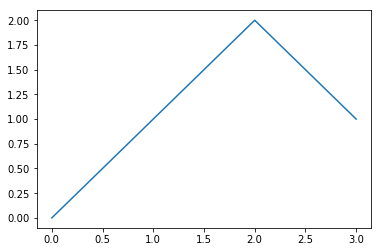

In [103]:
plt.plot([0,1,2,1])

In [596]:
b=.08*1e-3

In [597]:
a=.25*1e-3

In [598]:
k=2*pi/(795*1e-9)

In [599]:
wt=0

In [600]:
C=1

In [601]:
L=1.9

In [602]:
d=.03

In [603]:
def alpha(y):
    return k*a*y/(2*L)

In [604]:
def beta(y):
    return k*b*y/(2*L)

In [605]:
def E(y):
    return b*C*(sin(beta(y)) / beta(y)) * (sin(wt-k*L) + sin(wt-k*L+2*alpha(y)))

In [606]:
def E_lo(y):
    return C*exp(1j*k*d*y/L)

b=.08
a=.25

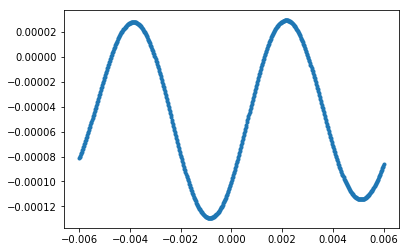

In [607]:
y = linspace(-.006,.006,600)

plt.plot(y,E(y),".-")

In [469]:
def E2(y):
    return 2*b*C*(sin(beta(y))/ beta(y))*cos(alpha(y))*sin(wt - k*L + alpha(y))

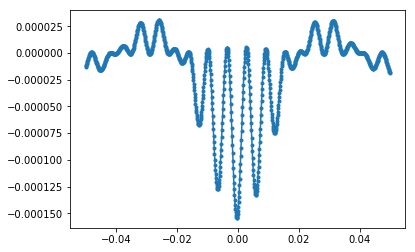

In [470]:
y = linspace(-.05,.05,1024)

plt.plot(y,E2(y),".-")

d=.03

In [608]:
d=.03

/home/photon/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


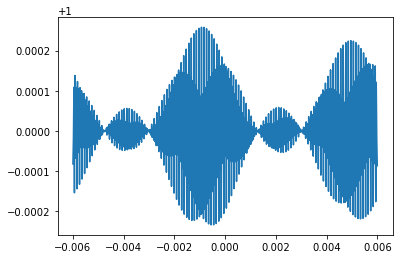

In [611]:
y = linspace(-.006,.006,600)
TotalIntensity=(E(y)+E_lo(y))*(E(y)+E_lo(y)).conj()
plt.plot(y,TotalIntensity)

(200, 250)

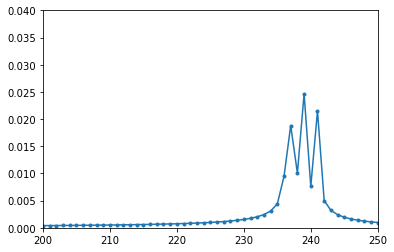

In [616]:
plt.plot(abs(fft(TotalIntensity)),".-")

plt.ylim([0,.04])

plt.xlim([200,250])


d=.35

In [474]:
d=.35

/home/photon/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


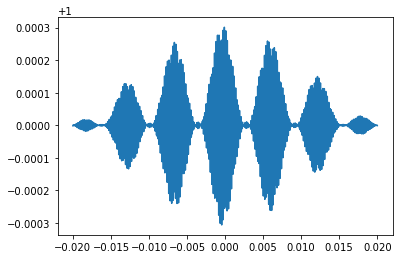

In [475]:
y = linspace(-.02,.02,1024)
TotalIntensity=(E(y)+E_lo(y))*(E(y)+E_lo(y)).conj()
plt.plot(y,TotalIntensity)

(0, 0.05)

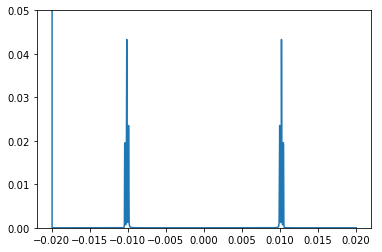

In [490]:
plt.plot(y,abs(fft(TotalIntensity)))

plt.ylim([0,.05])

d=.04

In [477]:
d=.04

/home/photon/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


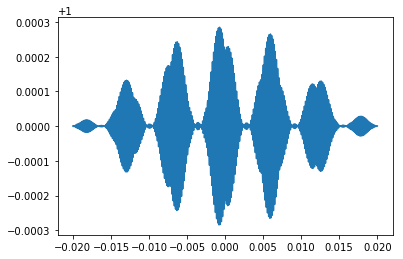

In [493]:
y = linspace(-.02,.02,1024)
TotalIntensity=(E(y)+E_lo(y))*(E(y)+E_lo(y)).conj()
plt.plot(y,TotalIntensity)

(0, 0.05)

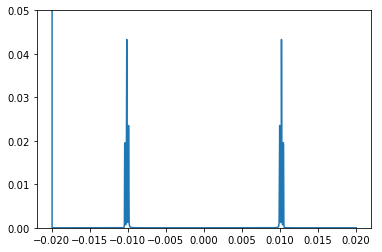

In [494]:
plt.plot(y,abs(fft(TotalIntensity)))

plt.ylim([0,.05])

d=.05

In [495]:
d=.05

/home/photon/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


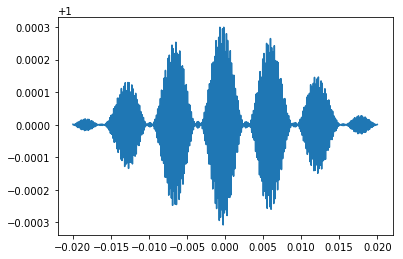

In [496]:
y = linspace(-.02,.02,1024)
TotalIntensity=(E(y)+E_lo(y))*(E(y)+E_lo(y)).conj()
plt.plot(y,TotalIntensity)

(0, 0.05)

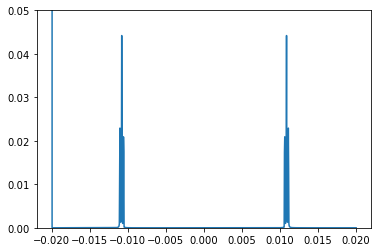

In [499]:
plt.plot(y,abs(fft(TotalIntensity)))

plt.ylim([0,.05])

d=.02

In [500]:
d=.02

/home/photon/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


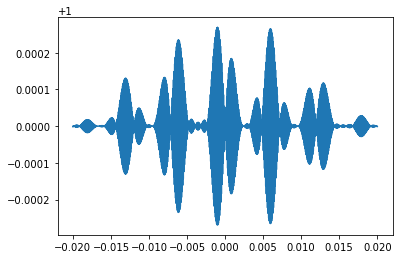

In [501]:
y = linspace(-.02,.02,1024)
TotalIntensity=(E(y)+E_lo(y))*(E(y)+E_lo(y)).conj()
plt.plot(y,TotalIntensity)

(0, 0.045)

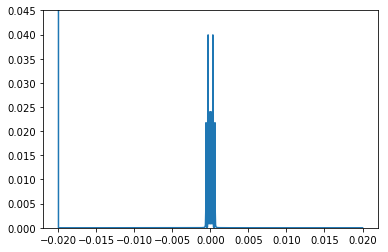

In [506]:
plt.plot(y,abs(fft(TotalIntensity)))

plt.ylim([0,.045])

d=.01

In [507]:
d=.01

/home/photon/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


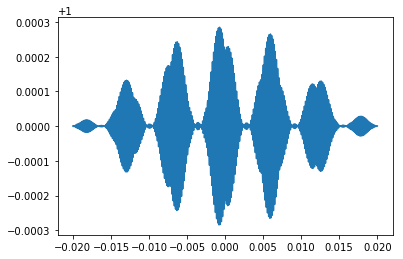

In [509]:
y = linspace(-.02,.02,1024)
TotalIntensity=(E(y)+E_lo(y))*(E(y)+E_lo(y)).conj()
plt.plot(y,TotalIntensity)

(0, 0.05)

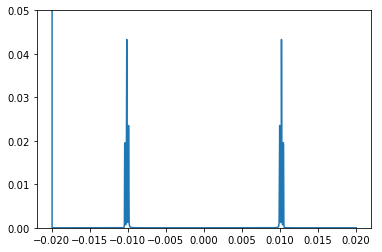

In [511]:
plt.plot(y,abs(fft(TotalIntensity)))

plt.ylim([0,.05])

b=.08
a=.5
d=.03

In [512]:
b=.08*1e-3

In [513]:
a=.5*1e-3

In [514]:
d=.03

In [515]:
def alpha(y):
    return k*a*y/(2*L)

In [516]:
def beta(y):
    return k*b*y/(2*L)

In [517]:
def E(y):
    return b*C*(sin(beta(y)) / beta(y)) * (sin(wt-k*L) + sin(wt-k*L+2*alpha(y)))

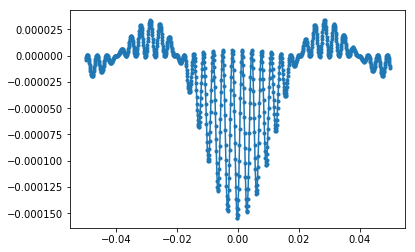

In [518]:
y = linspace(-.05,.05,1024)

plt.plot(y,E(y),".-")

/home/photon/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


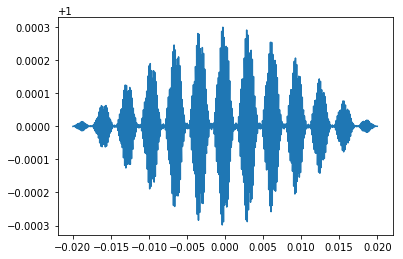

In [519]:
y = linspace(-.02,.02,1024)
TotalIntensity=(E(y)+E_lo(y))*(E(y)+E_lo(y)).conj()
plt.plot(y,TotalIntensity)

(0, 0.04)

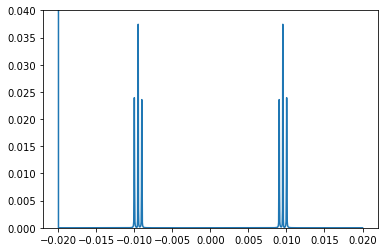

In [520]:
plt.plot(y,abs(fft(TotalIntensity)))

plt.ylim([0,.04])

d=.01

In [521]:
d=.01

/home/photon/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


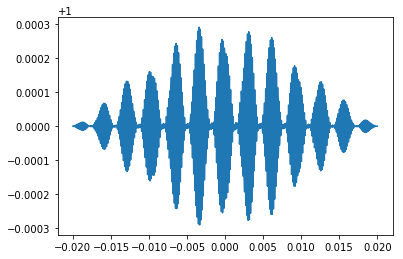

In [522]:
y = linspace(-.02,.02,1024)
TotalIntensity=(E(y)+E_lo(y))*(E(y)+E_lo(y)).conj()
plt.plot(y,TotalIntensity)

(0, 0.05)

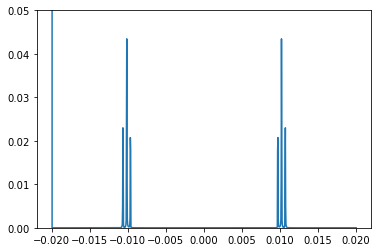

In [525]:
plt.plot(y,abs(fft(TotalIntensity)))

plt.ylim([0,.05])

d=.02

In [591]:
d=.03

/home/photon/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-0.002, 0)

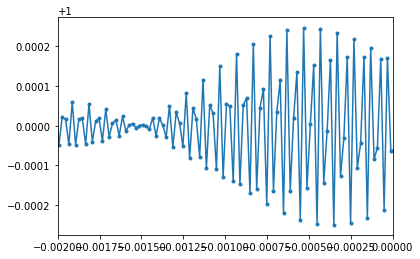

In [592]:
y = linspace(-.006,.006,600)
TotalIntensity=(E(y)+E_lo(y))*(E(y)+E_lo(y)).conj()
plt.plot(y,TotalIntensity,".-")
plt.xlim([-.002,0])

(200, 250)

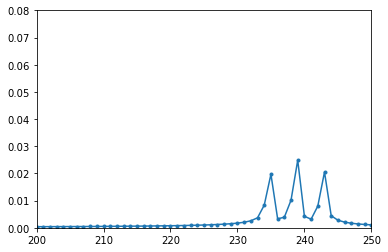

In [594]:
plt.plot(abs(fft(TotalIntensity)),".-")

plt.ylim([0,.08])

plt.xlim([200,250])

d=.04

In [533]:
d=.04

/home/photon/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


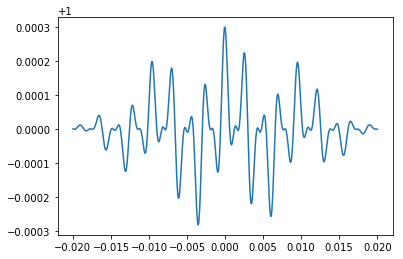

In [534]:
y = linspace(-.02,.02,1024)
TotalIntensity=(E(y)+E_lo(y))*(E(y)+E_lo(y)).conj()
plt.plot(y,TotalIntensity)

(0, 0.05)

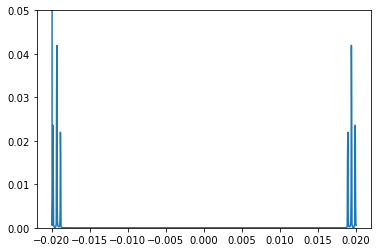

In [538]:
plt.plot(y,abs(fft(TotalIntensity)))

plt.ylim([0,.05])

d=.05

In [539]:
d=.05

/home/photon/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


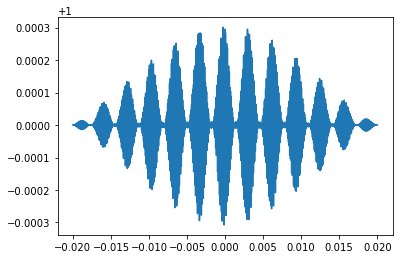

In [544]:
y = linspace(-.02,.02,2048)
TotalIntensity=(E(y)+E_lo(y))*(E(y)+E_lo(y)).conj()
plt.plot(y,TotalIntensity)

(0, 0.05)

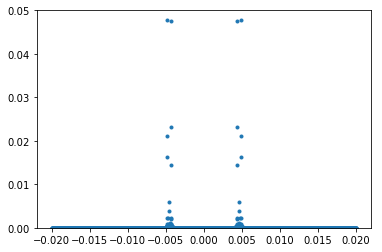

In [546]:
plt.plot(y,abs(fft(TotalIntensity)),".")

plt.ylim([0,.05])

#plt.xlim([-.015,-.005])

/home/photon/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(275, 325)

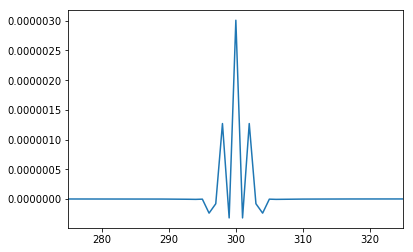

In [626]:
noLo = E(y)**2
noLo
plt.plot(fftshift(fft(noLo)))
plt.xlim([275,325])